# Shaded Topography/Relief

Created and tested by A. Newman on 9/23/2022

Many plots can be helped by showing shaded relief to relate surface geomorphic structure either by itself or with other data.  

A bit of caution!  Once you learn and are capable of doing these plots, there is a tendancy to overuse it.  Remember, only show on a plot what is necessary to convey ideas.  Other information is noise that detracts from the work.

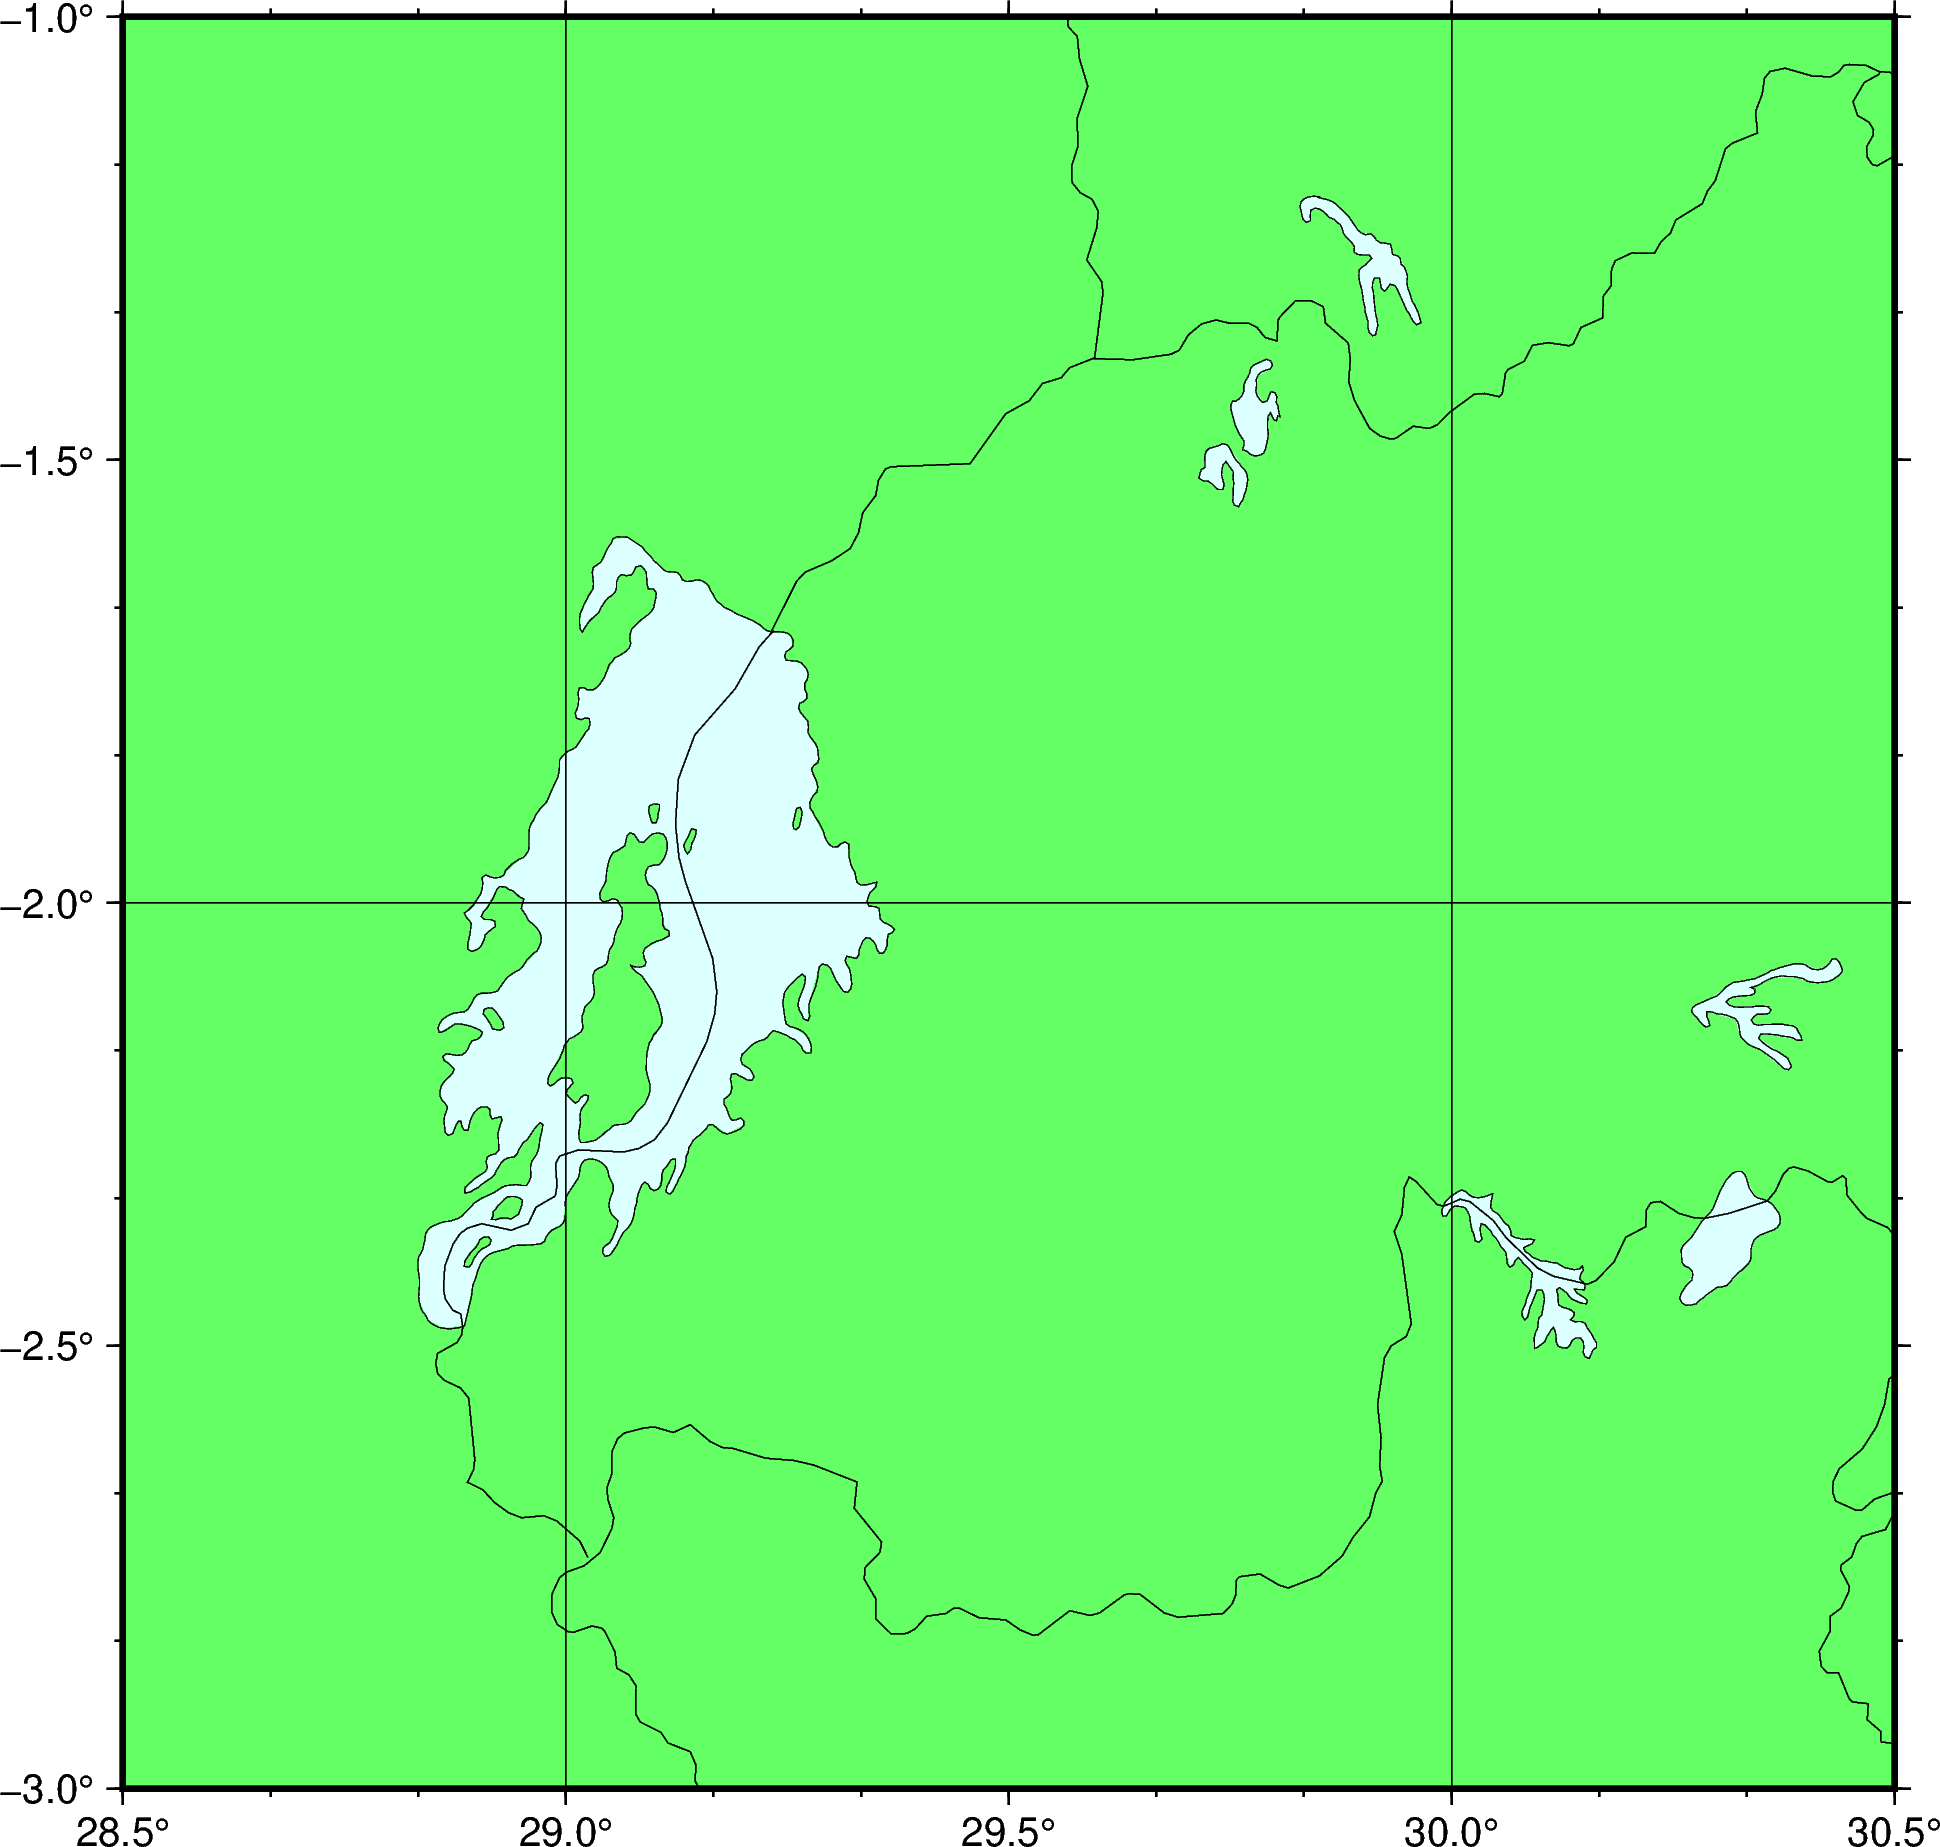

In [1]:
# Rwanda-Kivu Rift region
# we will start by making a prelim plot to assure that this is the region we want

import pygmt
xmin=28.5; xmax=30.5; ymin=-3;ymax=-1
region=[xmin,xmax,ymin,ymax]

fig1=pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain", # no alternating B&W 
             FORMAT_GEO_MAP='ddd.x') # decimal degrees
fig1.coast(region=region,  # xmin,xmax,ymin,ymax
           frame=['p','WSen','xa0.25g1', 'ya.25g1'], 
           land='100/255/100', water='220/255/255',
           resolution='h', 
           borders=1
          )
fig1.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
           resolution='f'
          )


fig1.show()

### Download high-resolution DEM
**S**huttle **R**adar **T**opography **M**ission high resolution data are available through the `elevation` package.  We will request only what we need

In [2]:
import elevation
import os

# gets proper path declaration independent of OS
# this will default to the global 90m resolution --way big enough for us
DEM=os.path.join(os.getcwd(),'mapdata','Rwanda_DEM.tif') 

# should define product='SRTM3' = 90m data (3arcsec), otherwise will default to 1arcsec
elevation.clip(bounds=(xmin,ymin,xmax,ymax),output=DEM,product='SRTM3')
elevation.clean()  # allows us to rerun get command

pygmt.grdinfo(DEM) # shows useful information about the grid file

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM3.vrt SRTM3.80c4526d1c4240d19ffb3a0275d6bc00.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 28.5 -1.0 30.5 -3.0 SRTM3.80c4526d1c4240d19ffb3a0275d6bc00.vrt /Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif
rm -f SRTM3.80c4526d1c4240d19ffb3a0275d6bc00.vrt
find cache -size 0 -name "*.tif" -delete
rm -f SRTM1.*.vrt
rm -f -r spool/*


'/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: Title: Grid imported via GDAL\n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: Command: \n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: Remark: \n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: Pixel node registration used [Geographic grid]\n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: Grid file format: gd = Import/export through GDAL\n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: x_min: 28.5 x_max: 30.5 x_inc: 0.000833333333333 (3 sec) name: x n_columns: 2400\n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: y_min: -3 y_max: -1 y_inc: 0.000833333333333 (3 sec) name: y n_rows: 2400\n/Users/anewman/Documents/Classes/PracticalCoding_2022/mapping/mapdata/Rwanda_DEM.tif: v_m

## Create initial DEM plot 
to assure things are working.  

Default GMT CPT choices are [shown here](https://docs.generic-mapping-tools.org/latest/cookbook/cpts.html#of-colors-and-color-legends)

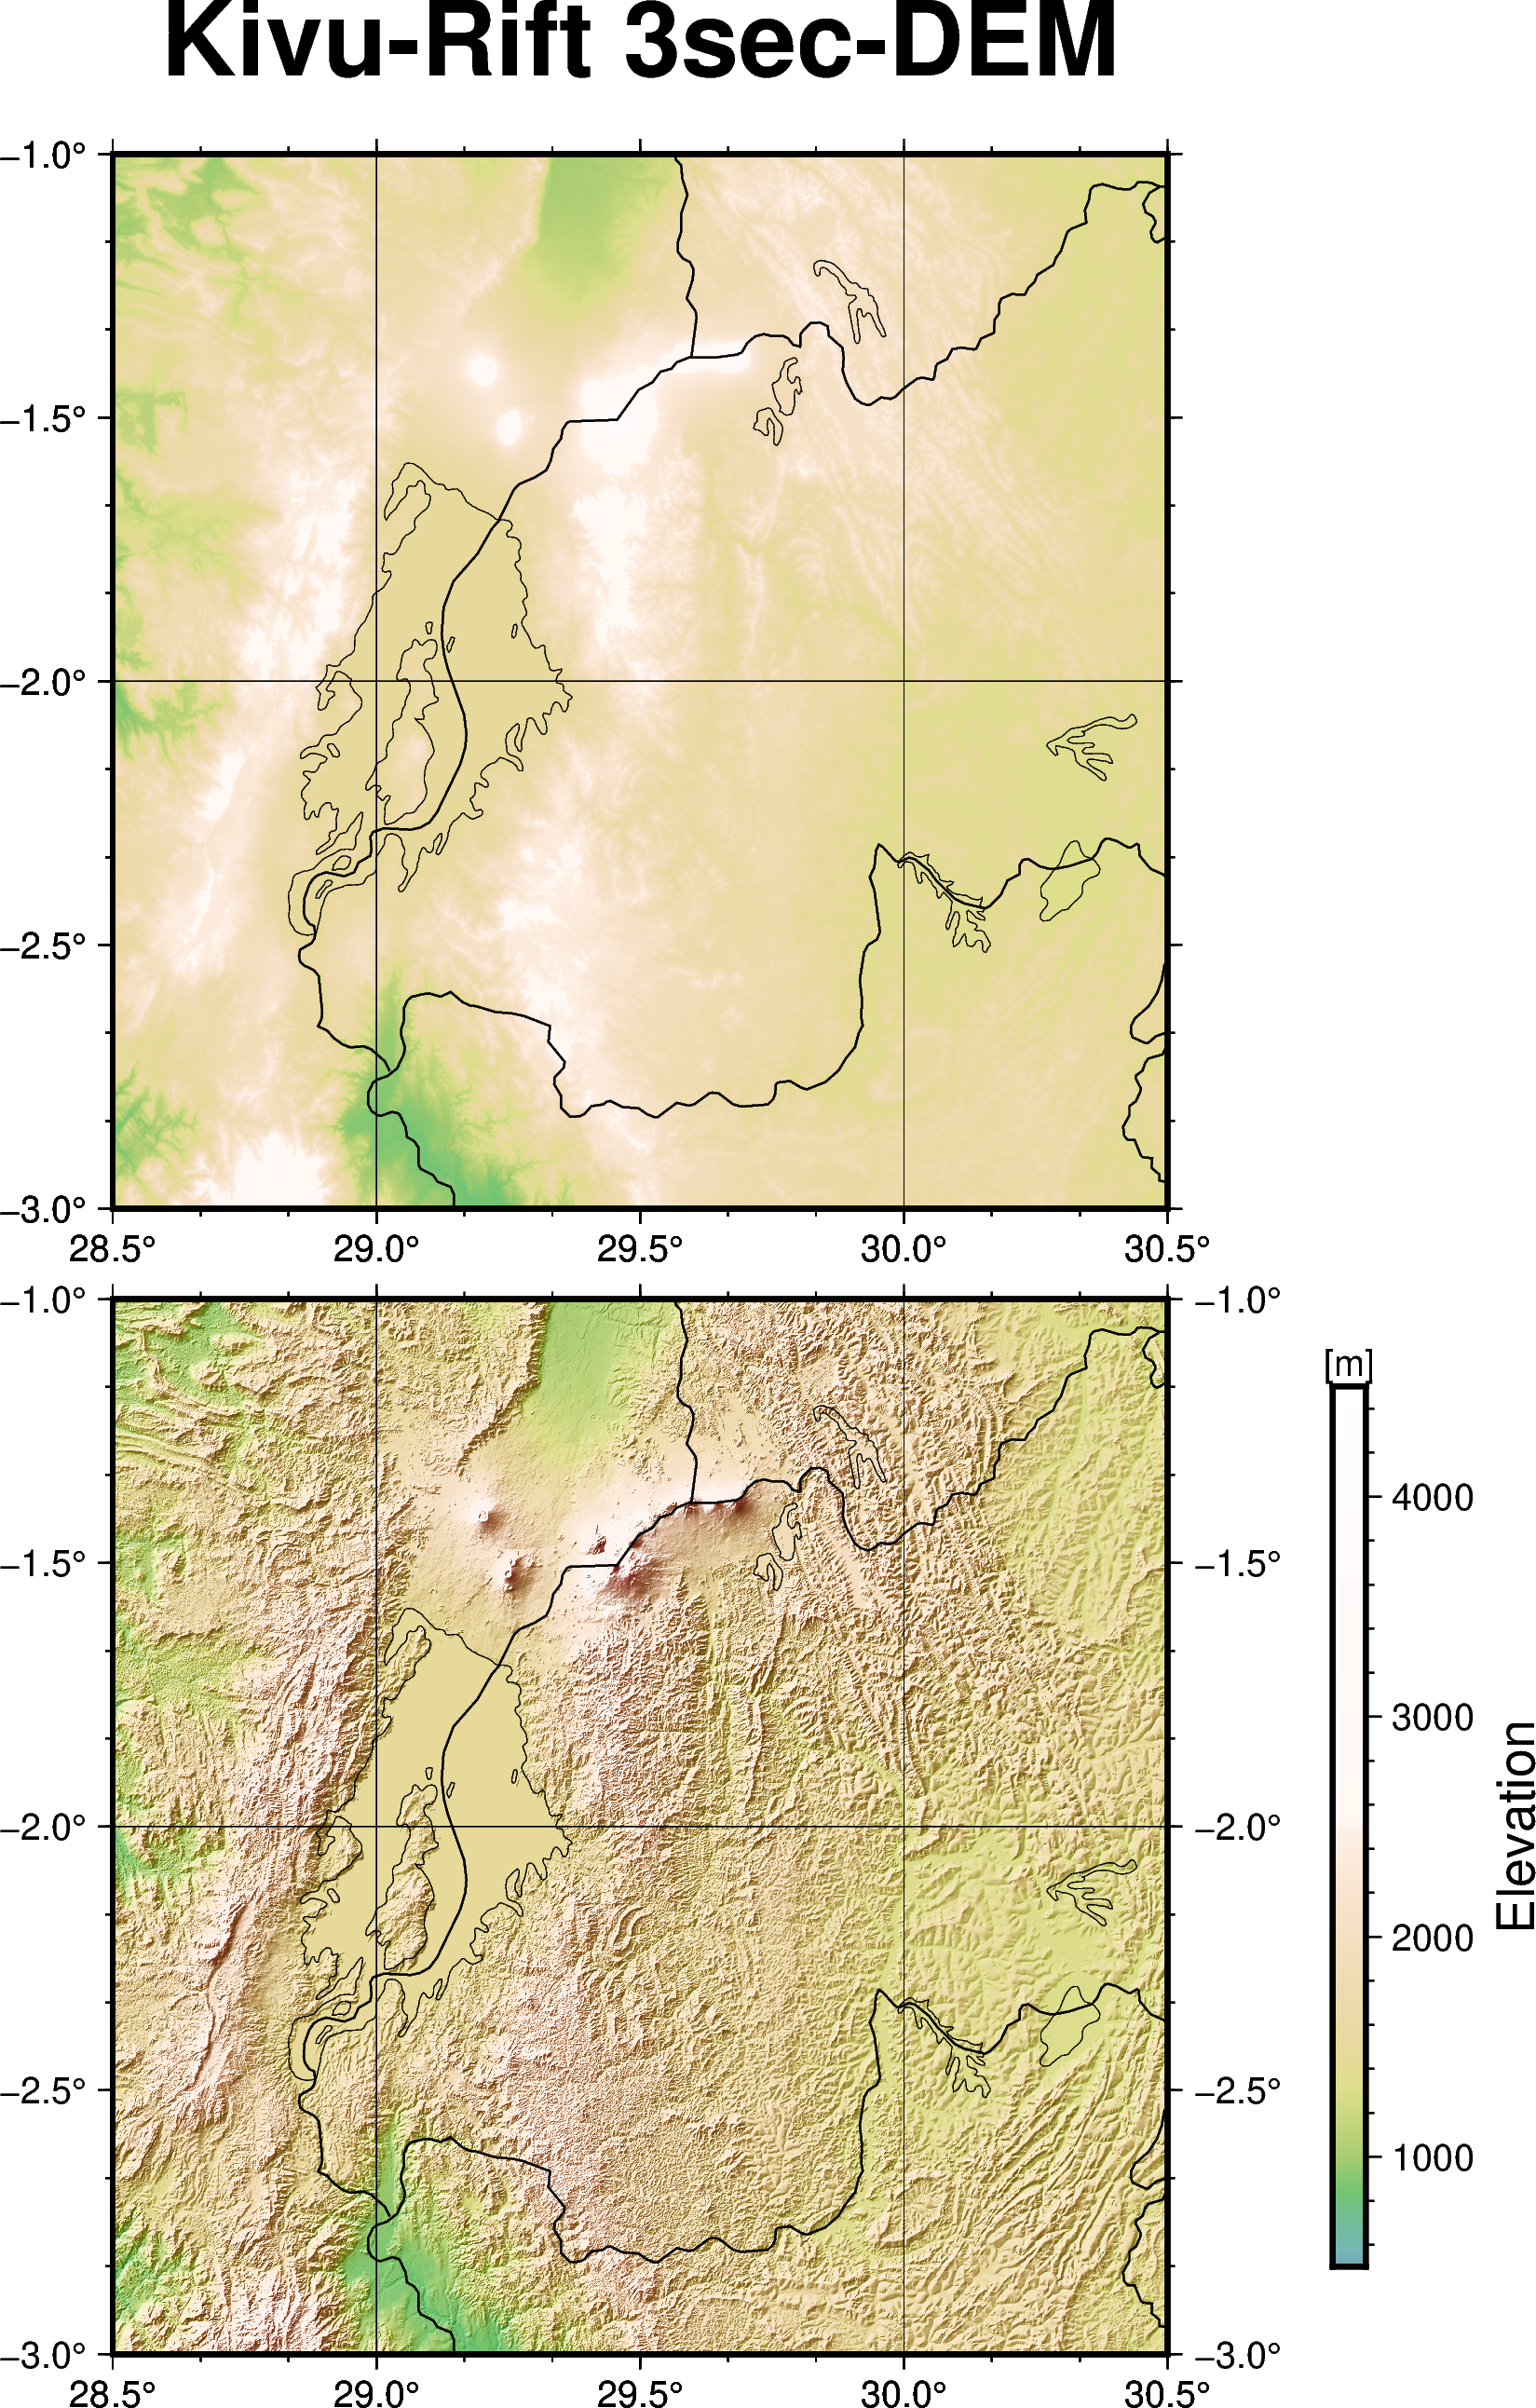

In [3]:
fig2=pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain", # no alternating B&W 
             FORMAT_GEO_MAP='ddd.x') # decimal degrees
pygmt.makecpt(series=[500,4500,500],
              continuous=True,
              cmap='topo')
with fig2.subplot(nrows=2,ncols=1,figsize=('10c','20c'),
              title='Kivu-Rift 3sec-DEM'):
    with fig2.set_panel(panel=0):
        fig2.grdimage(DEM,cmap=True) # Use globe version (all high elev.)
        fig2.coast(region=[xmin,xmax,ymin,ymax],  # xmin,xmax,ymin,ymax
            frame=['p','WSen','xa0.25g1', 'ya.25g1'], 
            resolution='h', 
            borders='1/0.5p'
            )
        fig2.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
            resolution='f'
            )
    with fig2.set_panel(panel=1):
        fig2.grdimage(DEM,cmap=True,shading=True) # Use globe version (all high elev.)
        fig2.coast(region=[xmin,xmax,ymin,ymax],  # xmin,xmax,ymin,ymax
            frame=['p','ESen','xa0.25g1', 'ya.25g1'], 
            resolution='h', 
            borders='1/0.5p'
            )
        fig2.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
            resolution='f'
            )
        fig2.colorbar(position="JMR+o1.5c/0c+w8c/0.3c", 
                      frame=['x+lElevation','y+l[m]'])
        
fig2.show()

## Complicated shaded-relief plot with overlaid data

In [4]:
# plot a specific earthquake on a global map with
#    plate boundaries, and prior earthquakes (depth-colored)

fig3=pygmt.Figure()
eloc=[-85,10.5]
libdir=os.path.join(os.getcwd(),'mapdata')
eventname='Nicoya_2012'

# make basemap    
scale=15
proj="G"+str(eloc[0])+"/"+str(eloc[1])+"/"+str(scale)+"c" # define projection up front
grid = pygmt.datasets.load_earth_relief(resolution="30m")
#    dgrid = gmt.grdgradient(grid=grid, radiance=[45, 80])
mapcpt=os.path.join(libdir,'map_gray.cpt') # use my favorite light shade
with pygmt.config(MAP_FRAME_PEN="0.3p,black"):
    fig3.grdimage(grid=grid, cmap=mapcpt, shading=True, 
                  projection=proj,transparency=50)
    fig3.coast(shorelines="0.2p,50", area_thresh=100000, 
               frame="afg30", projection=proj)

# background earthquakes
eqcpt=os.path.join(libdir,'eq_color.cpt') # my color scale for EQs
eqs=os.path.join(libdir,'EQM4plus.data.sorted')
fig3.plot(data=eqs, style='c', cmap=eqcpt, 
          pen='0.2,100', transparency=20)
fig3.colorbar(cmap=eqcpt,position="x13.7/0.2+w2.5c/0.2c+v")

# Plates
plates=os.path.join(libdir,'PB2002_plates.txt') # global plate DB
fig3.plot(data=plates, pen='0.5,0', transparency=10)

# plot event location in center
fig3.plot(x=eloc[0],y=eloc[1], 
          style="a0.85c",color="green",pen="1p,black", 
          transparency=50)

# add text (creating a new projection normalized from 0-1)
with pygmt.config(MAP_FRAME_PEN="0,white"):
    proj2="X"+str(scale)+"c"
    fig3.basemap(region=[0,1,0,1], projection=proj2,frame='wesn')
    fig3.text(text='EQ Depth [km]',x=0.89,y=0.015, 
              justify="LM", font="9p,Helvetica,black", angle=90)
    fig3.text(text='Event: '+str(eventname),x=0.015,y=0.97, 
              justify="LM", font="10p,Helvetica,black", angle=0)
 
fig3.savefig('StationMap_'+eventname+'.png',
             anti_alias=True, dpi=300,show=True)
#fig3.show()